# Matrix completion and recommender systems


[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.

This data set consists of:

- 100000 ratings (1-5) from 943 rows on 1682 movies.
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. rows and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of

```
user id | item id | rating | timestamp
```


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

Read the dataset from the `movielens.csv` file.


In [17]:
dataset = pd.read_csv("data/movielens.csv", sep="\t", header=None)
print(dataset.describe())
print(dataset)

                  0              1              2             3
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08
         0     1  2          3
0      196   242  3  881250949
1      186   302  3  891717742
2       22   377  1  878887116
3      244    51  2  880606923
4      166   346  1  886397596
...    ...   ... ..        ...
99995  880   476  3  880175444
99996  716   204  5  879795543
99997  276  1090  1  874795795
99998   13   225  2  882399156
99999   12   203  3  879959583

[100000 rows x 4 columns]


How many cols? How many people? How many ratings?


In [18]:
# number of users
rows = np.array(dataset[0]) - 1
n = rows.max() + 1
print("Number of users: %d" % n)

# number of movies
cols = np.array(dataset[1]) - 1
p = cols.max() + 1
print("Number of movies: %d" % p)

# number of ratings
values = np.array(dataset[2])
d = len(values)
print("Number of ratings: %d" % d)

Number of users: 943
Number of movies: 1682
Number of ratings: 100000


Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).


In [19]:
idx = np.arange(d)
np.random.seed(15)
np.random.shuffle(idx)
rows = rows[idx]
cols = cols[idx]
values = values[idx]

Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.


In [20]:
training_idx = idx[:80000]
testing_idx = idx[80000:]

print(training_idx.size)
print(testing_idx.size)

training_rows = rows[training_idx]
training_cols = cols[training_idx]
training_values = values[training_idx]

testing_rows = rows[testing_idx]
testing_cols = cols[testing_idx]
testing_values = values[testing_idx]

testing_idx

80000
20000


array([46995, 90315,  3525, ...,  8076, 52981,  7624])

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:

$$
X_{i,j} =
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$


In [113]:
X = csr_matrix((training_values, (training_rows, training_cols))).toarray()
X

array([[0, 0, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]])

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:

$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$

where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):

$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$

and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):

$$
\rho =
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$

where

$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r_{ij}
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r^{\text{pred}}_{ij}
\end{split}
$$


In [137]:
# compute r_(i,j)^pred for each user
avg_values = np.array([np.mean(training_values[training_rows == i]) for i in range(n)])

pred_values_trivial = avg_values[testing_rows]
error = testing_values - pred_values_trivial

RMSE_trivial = np.sqrt(np.mean(error**2))
rho_trivial = pearsonr(testing_values, pred_values_trivial)[0]
print("RMSE = %f" % RMSE_trivial)
print("pearson rho = %f" % rho_trivial)

RMSE = 1.048945
pearson rho = 0.364646


# Singular value truncation (SVT) based recommender system


Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.


In [155]:
final_RMSE_trend = []
final_rho_trend = []

In [165]:
thresholds = np.array((50, 75, 100, 125, 150, 175, 200, 225, 250))
s_thresh = 50.0
tolerance = 1.0e-6
max_iter = 100

RMSE_SVT_trend = np.zeros(max_iter)
rho_SVT_trend = np.zeros(max_iter)

for s_thresh in thresholds:
    X_hat = X.copy()
    for k in range(max_iter):
        X_hat_old = X_hat.copy()
        U, s, VT = np.linalg.svd(X_hat, full_matrices=False)
        s[s < s_thresh] = 0
        X_hat = U @ np.diag(s) @ VT
        X_hat[training_rows, training_cols] = training_values

        pred_values = X_hat[testing_rows, testing_cols]
        error = testing_values - pred_values
        RMSE_SVT_trend[k] = np.sqrt(np.mean(error**2))
        rho_SVT_trend[k] = pearsonr(testing_values, pred_values)[0]

        increment = np.linalg.norm(X_hat - X_hat_old)
        print("current threshold value: %1.0f" % s_thresh)
        print("Iteration %d, inrement from previous iteration: %1.2f" % (k, increment))
        print("RMSE = %1.2f" % RMSE_SVT_trend[k])
        print("pearson rho = %1.2f" % rho_SVT_trend[k])

        if increment < tolerance:
            break
    RMSE_SVT_trend = RMSE_SVT_trend[(RMSE_SVT_trend != 0)]
    rho_SVT_trend = rho_SVT_trend[(rho_SVT_trend != 0)]
    final_RMSE_trend.append(RMSE_SVT_trend[-1])
    final_rho_trend.append(rho_SVT_trend[-1])

current threshold value: 50
Iteration 0, inrement from previous iteration: 389.94
RMSE = 3.13
pearson rho = 0.14
current threshold value: 50
Iteration 1, inrement from previous iteration: 201.39
RMSE = 2.92
pearson rho = 0.14
current threshold value: 50
Iteration 2, inrement from previous iteration: 134.56
RMSE = 2.81
pearson rho = 0.15
current threshold value: 50
Iteration 3, inrement from previous iteration: 99.98
RMSE = 2.73
pearson rho = 0.15
current threshold value: 50
Iteration 4, inrement from previous iteration: 78.84
RMSE = 2.68
pearson rho = 0.15
current threshold value: 50
Iteration 5, inrement from previous iteration: 64.57
RMSE = 2.64
pearson rho = 0.16
current threshold value: 50
Iteration 6, inrement from previous iteration: 54.31
RMSE = 2.62
pearson rho = 0.16
current threshold value: 50
Iteration 7, inrement from previous iteration: 46.60
RMSE = 2.59
pearson rho = 0.16
current threshold value: 50
Iteration 8, inrement from previous iteration: 40.61
RMSE = 2.57
pearson 

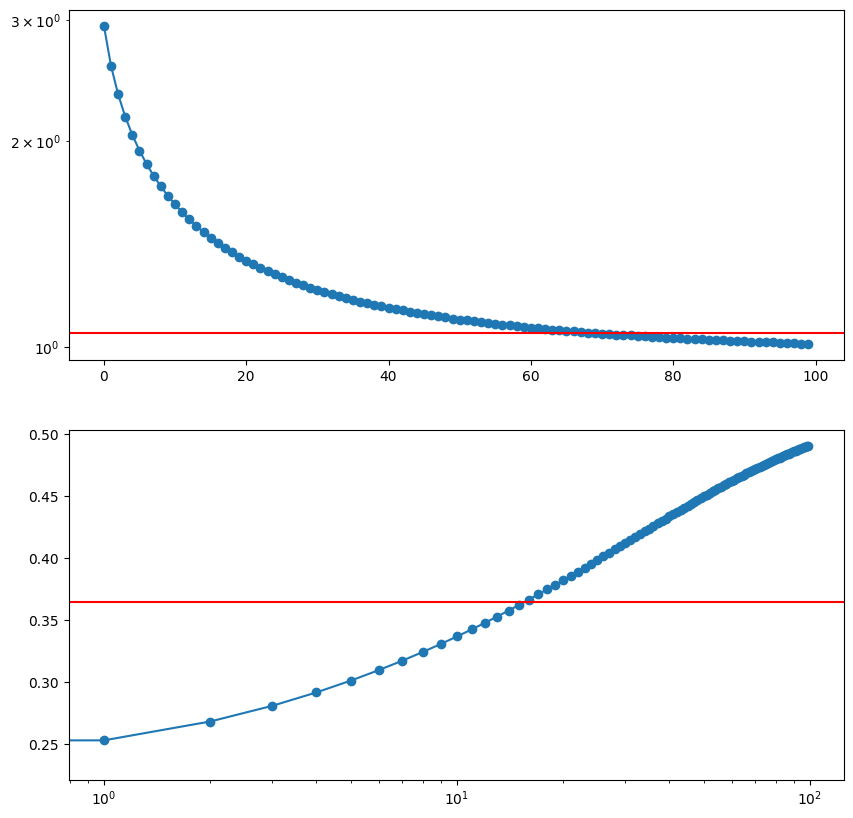

In [167]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].semilogy(RMSE_SVT_trend, "-o")
axs[0].axhline(RMSE_trivial, color="red")
axs[1].semilogx(rho_SVT_trend, "-o")
axs[1].axhline(rho_trivial, color="red")

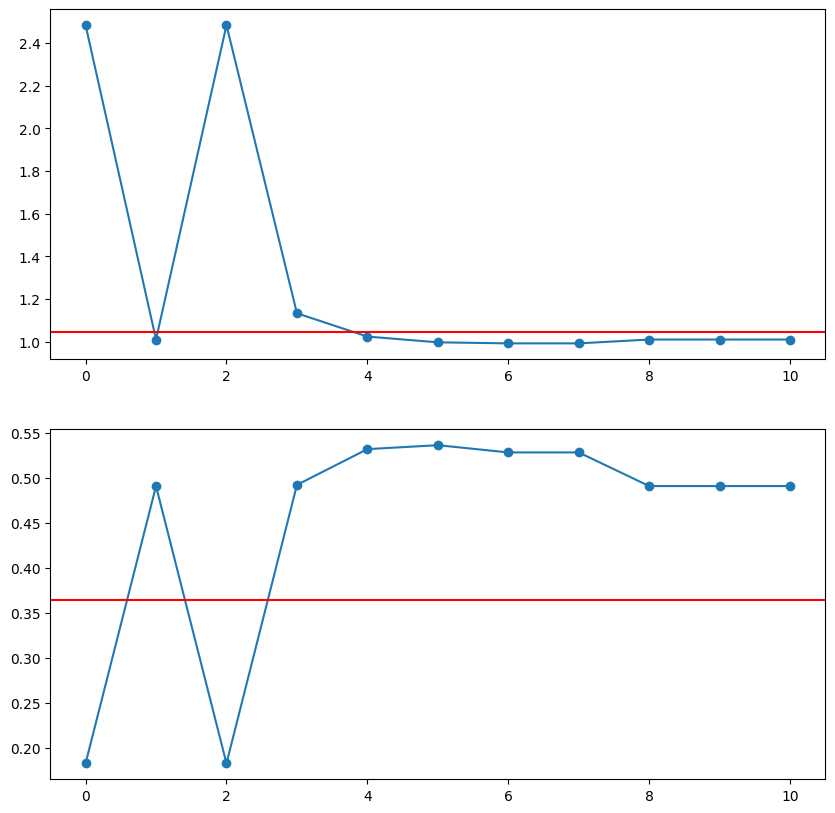

In [166]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(final_RMSE_trend, "-o")
axs[0].axhline(RMSE_trivial, color="red")
axs[1].plot(final_rho_trend, "-o")
axs[1].axhline(rho_trivial, color="red")